# Swing prediction

Predicting when a batter is more likely to swing can be useful for a pitcher. For instance, it can be useful to determine how likely a batter will swing on a full count. If he is inclined to swing, then the batter could be suceptible to chasing pitches out of the strike zone.

Here, I'll look at a number of binary classifiers to predict whether a batter will swing his bat based on pitch trajectory and game situation information from the PitchFX database. While I focus on making a model for a particular batter (Jack Cust) using data from the 2008 season, the methods here can be extended to other batters.

In [1]:
# imports
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import subprocess
%matplotlib inline

## Building the database

PitchFX is a camera-based tracking system that measures the velocity, movement, release point, spin, and pitch location for every pitch thrown in baseball. It allows pitches to be analyzed in detail that was not previously available.

Unfortunately, PitchFX data is not readily available for download from Major League Baseball (MLB). Thus, I wrote my own script to scrape MLB's website and placed the data in an SQL database.

Building your database notebook:   
https://github.com/jasonpchang/pitchfx_sql/blob/master/notebooks/getting_started/read_data.ipynb

Web scraping code:  
https://github.com/jasonpchang/pitchfx_sql/blob/master/src/load_pitchfx_mod.py

## Quality control of the database

Because the PitchFX database contains detailed information about the trajectory of a pitch, a good approach to QC the data is to group/cluster pitches together based on their trajectories. For instance, a given pitcher typically has multiple distinct types of pitches, such as a fastball (fast and generally straight) and multiple types of breaking balls (slow with horizontal and vertical movement). These pitches should naturally group into distinct clusters when observed in velocity and horizontal/vertical acceleration dimensions.

An example of grouping pitches thrown by Barry Zito using hierarchical clustering with Ward linkage is shown below. Clusters are projected onto the starting speed and horizontal acceleration dimensions. Colors correspond to different pitch types.

<img style="float: left;" src="../../fig/classification.jpg">

Pitch clustering notebook:  
https://github.com/jasonpchang/pitchfx_sql/blob/master/notebooks/pitch_classification/pitch_classification.ipynb

## Loading data and creating the response

I'll start by loading information from the PitchFX database. In this notebook, I'll predict swings for Jack Cust, who was known for three things: hitting home runs, walks, and striking out. I'll create the response (swing or no swing) as well.

In [2]:
# specify database name
dbname = "../../dat/pitchfx2008.db"

# connect to the sqlite3 database
db = sqlite3.connect(dbname)
hdb = db.cursor()

To make SQL queries simpler, I created a `Player` class that extracts information from the database quickly and places the information in a pandas dataframe. Here, I'll grab the pitch trajectory and game situation information related to Jack Cust, as well as create a pandas dataframe containing physical attributes (i.e., handedness) of all players.

`Player` class code:  
https://github.com/jasonpchang/pitchfx_sql/blob/master/src/Player.py

In [3]:
# import classes
sys.path.append('../../src')
from Player import Player

# create player object
jc = Player("Jack Cust", db)

# grab pitches
jc_pitches = jc.pitches_against(clean=1).reset_index(drop=False)
# grab events
jc_events = jc.hit_events()
# grab games
jc_games = jc.hit_games()
# grab player table (for handedness of pitchers)
query = """SELECT *
        FROM players"""
players = pd.read_sql_query(query, db)

In [4]:
# list of swing outcomes
swings = ['Swinging Strike',
          'In play, out(s)',
          'In play, no out',
          'In play, run(s)',
          'Foul',
          'Foul Tip',
          'Foul (Runner Going)',
          'Swinging Strike (Blocked)']

# create feature of swings in pitches
jc_pitches['swing'] = np.array(list(map(lambda x: x in swings, jc_pitches['description'])))

In [5]:
# percentage of swings
print("percentage of pitches swung at: ", np.mean(jc_pitches['swing']))

percentage of pitches swung at:  0.381352541016


Overall, I see that Cust swings at 38% of the pitches he sees.

## Feature pre-processing

I'll now create the set of features I will use to predict swings for Jack Cust based on exploratory data analysis (not shown here). In general, I use the majority of the pitch trajectory information, as well as a number of game-situation related information (including score differential and pitch count).

Exploratory data analysis:  
https://github.com/jasonpchang/pitchfx_sql/blob/master/notebooks/swing_prediction/swing_prediction_eda.ipynb

I also engineer a number of features to include in the model, including differences in pitch trajectory between the current pitch and the previous pitch.

Feature engineering:  
https://github.com/jasonpchang/pitchfx_sql/blob/master/notebooks/swing_prediction/swing_prediction_random_forest.ipynb

In [6]:
# join four tables
features = jc_pitches.merge(jc_events,
                     left_on=['game_id', 'cur_event'],
                     right_on=['game_id', 'event_id'],
                     how='left',) \
              .merge(jc_games,
                     left_on=['game_id'],
                     right_on=['game_id'],
                     how='left',) \
              .merge(players[['player_id', 'throws']].drop_duplicates(),
                     left_on=['pitcher_id'],
                     right_on=['player_id'],
                     how='left',) \
              .sort_values(by=['game_id', 'cur_event'])

# pitch information to calculate gradients of
grad_f = ['start_speed', 'end_speed', 'pfx_x', 'pfx_z', 'px', 'pz', 'x', 'y', 'x0', 'z0', 'vx0',
          'vy0', 'vz0', 'ax', 'ay', 'az', 'break_y', 'break_angle', 'break_length', 'spin_dir', 'spin_rate']
for ff in grad_f:
    features['grad_%s' %(ff)] = -features[ff].diff(1)
    
# get previous pitch swing information
features['prev_swing'] = features['swing'].shift(1)
features['prev_swing'] = features['prev_swing'].fillna(False)
    
# impute nans with column means
features = features.fillna(features.mean())

# pitcher handedness (0: left, 1: right)
features['throws'].replace(['L', 'R'], [0, 1], inplace=True)

# score differential (relative to batter's team)
myteam = features['pre_home_score'].copy()
myteam[features['is_top_inning']==True] = features[features['is_top_inning']==True]['pre_away_score']
otherteam = features['pre_away_score'].copy()
otherteam[features['is_top_inning']==True] = features[features['is_top_inning']==True]['pre_home_score']
features['my_score'] = myteam
features['other_score'] = otherteam
features['score_diff'] = myteam-otherteam
features = features.drop(['pre_home_score', 'pre_away_score'], axis=1)

# ball-strike differential
features['count_diff'] = features['pre_balls']-features['pre_strike']

In [7]:
# drop columns
dropped_indices = ['index', 'game_id', 'cur_event', 'outcome', 'post_balls', 'post_strike',
                   'sz_top', 'sz_bot', 'y0', 'event_id', 'description', 'event_description',
                   'post_1b', 'post_2b', 'post_3b', 'post_home', 'post_home_score',
                   'post_away_score', 'game_type', 'game_time', 'home_id', 'visit_id', 
                   'umpire_home', 'umpire_first', 'umpire_second', 'umpire_third', 
                   'player_id', 'post_out', 'batter_id', 'pitch_type', 'date', 'stadium_id', 
                   'home_wins', 'home_losses', 'visit_wins', 'visit_losses', 'pitcher_id',
                   'at_bat', 'pitch_num', 'x', 'grad_x', 'y', 'grad_y', 'end_speed',
                   'grad_end_speed','vy0',  'grad_vy0', 'pfx_x', 'grad_pfx_x', 'pfx_z',
                   'grad_pfx_z', 'break_length', 'grad_break_length']

features = features.drop(dropped_indices, axis=1)

In the end, I have a total of 43 features (excluding `swing`) which are listed below.

In [8]:
print(features.columns)

Index(['time', 'pre_balls', 'pre_strike', 'start_speed', 'px', 'pz', 'x0',
       'z0', 'vx0', 'vz0', 'ax', 'ay', 'az', 'break_y', 'break_angle',
       'spin_dir', 'spin_rate', 'swing', 'inning', 'is_top_inning', 'pre_out',
       'pre_1b', 'pre_2b', 'pre_3b', 'throws', 'grad_start_speed', 'grad_px',
       'grad_pz', 'grad_x0', 'grad_z0', 'grad_vx0', 'grad_vz0', 'grad_ax',
       'grad_ay', 'grad_az', 'grad_break_y', 'grad_break_angle',
       'grad_spin_dir', 'grad_spin_rate', 'prev_swing', 'my_score',
       'other_score', 'score_diff', 'count_diff'],
      dtype='object')


Next I'll randomly split the data into training and test sets. Here, I will use 70% of the data to be used for training the models.

In [9]:
# import
import sys
sys.path.append('../src')
from split_data import split_data

In [10]:
# creating training and test sets
y = features['swing'].astype('int')
features = features.drop('swing', axis=1)
X_train, X_test, y_train, y_test = split_data(features, y, 0.7, 0)

## Model fitting

I'll now fit the training data using various models, roughly from less to more flexible.

### Logistic regression

Logistic regression models the probability that a batter swings, given some features. Note that I will use cross-validation to determine a value for C, which determines the regularization strength for L1 and L2 regularization here. Smaller values correspond to stronger regularization (inverse of regularization strength).

In [11]:
# import
from sklearn.linear_model import LogisticRegressionCV

I'll first look at L2 regularization (ridge), followed by L1 regularization (lasso). I'll use three-fold cross-validation here to estimate the best value of C for each approach. Note that the features should be standardized prior to fitting, as the regularization term in the objective function is directly related to the coefficients and how the features are scaled.

In [12]:
# import
from sklearn.preprocessing import StandardScaler

# calculate scaling values
scaler = StandardScaler().fit(X_train)

# scale data based on training data
X_train_stand = scaler.transform(X_train)
X_test_stand = scaler.transform(X_test)

In [13]:
# fit ridge
rseed = 0
logregL2_fit = LogisticRegressionCV(Cs=10,
                                    cv=3,
                                    penalty='l2',
                                    solver='lbfgs',
                                    random_state=rseed,
                                    refit=True).fit(X_train_stand, y_train)
print("average cross validation error: ", np.min(1-logregL2_fit.scores_[1].mean(axis=0)))
print("logistic regression (ridge) test error: ", 1-np.mean(logregL2_fit.predict(X_test_stand)==y_test))

average cross validation error:  0.381446985446
logistic regression (ridge) test error:  0.391472868217


In [14]:
# fit lasso
logregL1_fit = LogisticRegressionCV(Cs=10,
                                    cv=3,
                                    penalty='l1',
                                    solver='liblinear',
                                    random_state=rseed).fit(X_train_stand, y_train)
print("average cross validation error: ", np.min(1-logregL1_fit.scores_[1].mean(axis=0)))
print("logistic regression (lasso) test error: ", 1-np.mean(logregL1_fit.predict(X_test_stand)==y_test))

average cross validation error:  0.379710870828
logistic regression (lasso) test error:  0.387596899225


The two models provide similar cross-validation and test errors, with L1 regularization performing slightly better than L2 regularization. This is potentially observed because some of the features might not actually be contributing anything to the response (although again the difference in test errors is small). Additionally, both cross-validation and test errors are quite high, potentially because the data are unlikely to be linearly separable (I have not pursued feature transformations, like polynomial representations or product of features, here).

### SVM

Support vector machines (SVM) allows for non-linear decision boundaries. I will look at radial basis functions here (linear regression is similar to SVM with a linear kernel), which makes this a non-parametric approach since the number of pairwise distances between training and new points grows with the size of the training set.

I will use cross-validation to find reasonable values for C (which controls the budget for violations of training data points of the margin) and gamma (which controls the local influence of a single training example on the decision boundary). Note that because radial basis functions rely on distances between test observatoins and training observations, I use the standardized features.

In [15]:
# imports
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# set values for tuning parameters
tuned_parameters = [{'kernel': ['rbf'],
                     'gamma': [1, 1e-1, 1e-2, 1e-3, 1e-4],
                     'C': [0.1, 1, 10, 100, 1000]},]

# use cross validation to find tuning parameters
svm_fit = GridSearchCV(SVC(cache_size=10000,
                           probability=True),
                       tuned_parameters,
                       cv=3,
                       scoring='accuracy').fit(X_train_stand, y_train)

In [16]:
# print best parameters
print("best C: ", svm_fit.best_params_['C'])
print("best gamma: ", svm_fit.best_params_['gamma'])

# calculate errors
print("cross validation error: ", 1-svm_fit.best_score_)
print("svm with rbf test error: ", 1-np.mean(svm_fit.predict(X_test_stand)==y_test))

best C:  10
best gamma:  0.01
cross validation error:  0.301449275362
svm with rbf test error:  0.248062015504


Using the parameters selected through cross-validation, I find a lower cross-validation error than logistic regression with regularization. Additionally, the test error is significantly lower using SVM than using logistic regression. Thus, a non-linear decision boundary appears better suited for this prediction problem than a linear decision boundary.

### Random forest

Finally, I'll fit a random forest model. Random forest has the advantages that it can display both low bias and low variance if results from a large number of decision trees are averaged. Additionally, random forest has a track record of good performance, can handle both regression and classification problems, and can also rank features based on influence on the response. Some drawbacks are that this approach can take up a lot of memory if the size of the dataset and the number of trees is large, and the forests themselves are a bit of a black box in terms of interpretability.

In [17]:
# import
from sklearn.ensemble import RandomForestClassifier

# initialize parameters
seed = 1000
nestimators = 1000

# initialize classifiers
rf_fit = RandomForestClassifier(n_estimators=nestimators,
                                criterion='gini',
                                max_features='sqrt',
                                random_state=seed,
                                oob_score=True,).fit(X_train, y_train)

For validating my model, I will look to examine the out-of-bag error, which is similar to cross-validation error. In random forest, a number of decision trees are built on bootstrapped data. Therefore, each tree is likely to leave out a subset of the training data. One can predict the reponse for each data point using results from trees where the data point was not used to build the tree (OOB). The final prediction for each data point is just the majority vote amongst total predictions (in the classification problem).

In [18]:
# out-of-bag error
print("out-of-bag error: ", 1-rf_fit.oob_score_)

# test error
print("test error: ", 1-np.mean(rf_fit.predict(X_test)==y_test))

out-of-bag error:  0.228405797101
test error:  0.220930232558


Both the OOB error and test errors are lower than the corresponding cross-validation and test errors from SVM.

Random forest provides estimates of feature importance based on the effect of splits on given features in the fitting process.

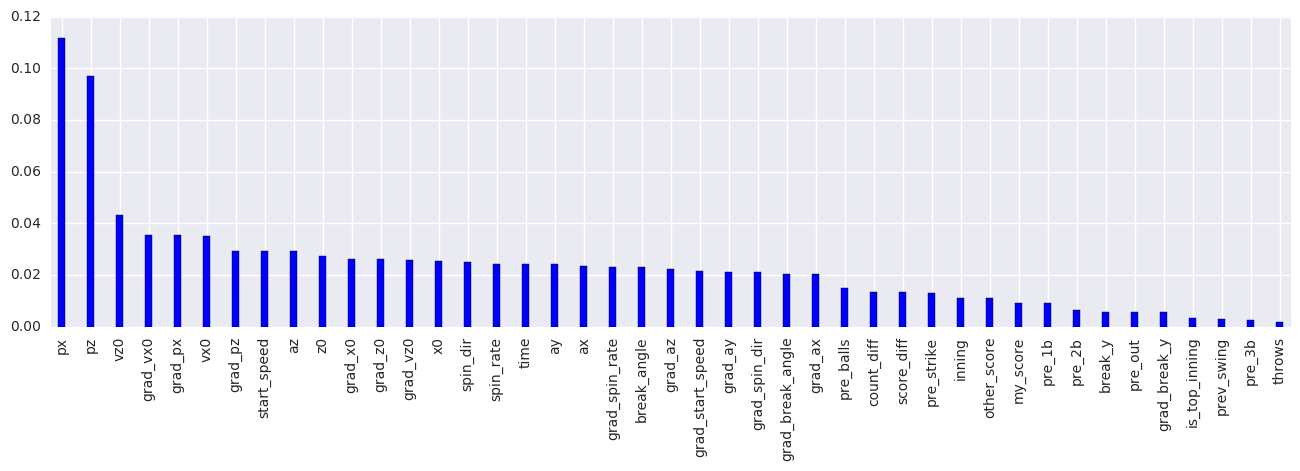

In [19]:
# feature importance plot
importance = pd.Series(rf_fit.feature_importances_,
                       index=X_train.columns)
indices = np.argsort(importance)[::-1]
importance[indices].plot.bar(color='blue', width=0.25, figsize=(16, 4))
plt.show()

It appears that the two most important features to determining whether Cust will swing his bat are horizontal and vertical pitch location (`px`, `pz`). This is expected, as batters usually try to swing at pitches in the strike zone and not outside of it. Then, it appears that the vertical velocity of the ball out of the pitcher's hand (`vz0`) is the next most important feature, suggesting that vertical movement of a pitch could be a useful feature for swing prediction. Note that the feature importances are biased towards features with more values/levels. This is observed here, where many of the binary features appear to have the least importance.

## Model comparison

To compare the performance of these different models, I plot the area under the ROC curves for each model and the test set.

In [20]:
# import
from sklearn.metrics import roc_auc_score, roc_curve

In [21]:
# calculate false positive and true negative rates
preds = [rf_fit.predict_proba(X_test)[:, 1],
         logregL2_fit.predict_proba(X_test_stand)[:, 1],
         logregL1_fit.predict_proba(X_test_stand)[:, 1],
         svm_fit.predict_proba(X_test_stand)[:, 1]]
dats = ['random forest',
        'logistic regression--L2',
        'logistic regression--L1',
        'svm',]

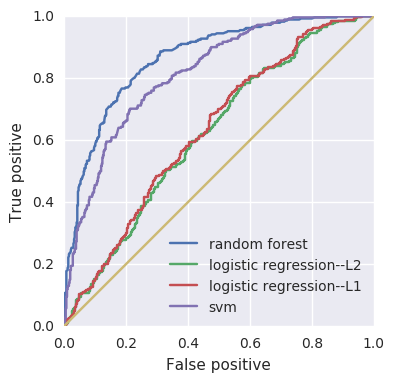

In [22]:
# plot curves
fig, ax = plt.subplots()
for pred in preds:
    false_pos, true_pos, _ = roc_curve(y_test, pred)
    ax.plot(false_pos, true_pos)
ax.plot([0, 1], [0, 1])
ax.legend(dats, loc=4)
ax.set_aspect('equal', 'box')
ax.set_xlabel('False positive')
ax.set_ylabel('True positive')
plt.show()

In [23]:
# calculate area under roc curve
print("Area under ROC curve:")
for ii in range(len(preds)):
    print(dats[ii], ":", roc_auc_score(y_test, preds[ii]))

Area under ROC curve:
random forest : 0.863930256352
logistic regression--L2 : 0.620516682772
logistic regression--L1 : 0.631153015404
svm : 0.815810975956


The area under the ROC curves suggest that the best model is random forest. Therefore, I choose my final model to be a random forest model. Finally, I produce a confusion matrix to determine the types of mistakes the random forest classifier is making.

Normalized confusion matrix
[[ 0.90248963  0.09751037]
 [ 0.42465753  0.57534247]]


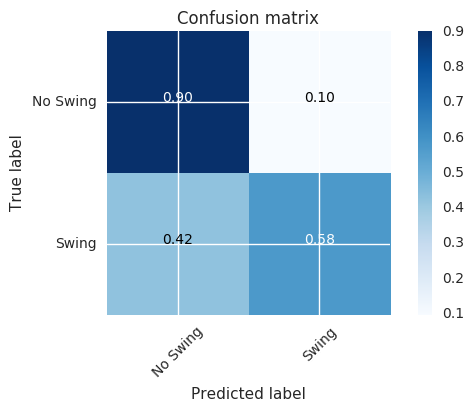

In [24]:
# import
import itertools
from sklearn.metrics import confusion_matrix

# calculate confusion matrix
cm = confusion_matrix(y_test, rf_fit.predict(X_test))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # clean up
    return plt

# plot confusion matrix
plot_confusion_matrix(cm,
                      classes=['No Swing', 'Swing'],
                      normalize=True,)
plt.show()

After normalizing the confusion matrix, it is clear that the classifier predicts non swings very well (high true negative rate). However, the classifier performs less effectively on predicting swings accurately (lower true positive rate). If interested in limiting the errors when the batter actually swings his bat, then decreasing the decision threshold from 0.5 could help.

I will also calculate the precision and recall of this model, along with the F-score.

In [25]:
# calculate precision, recall, and F-score
tn, fp, fn, tp = confusion_matrix(y_test, rf_fit.predict(X_test)).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
fscore = 2*(precision*recall)/(precision+recall)
print('Precision: ', precision)
print('Recall: ', recall)
print('F-score: ', fscore)

Precision:  0.781395348837
Recall:  0.575342465753
F-score:  0.662721893491


Precision is relatively high. Thus, when the classifier predicts swing, the batter usually swings. However, recall is relatively low. Thus, when the batter actually swings his bat, the classifier does not do a great job of predicting swing. Again, lowering the decision threshold could help here. Doing so would lead to more predictions of swing, which would increase the number of false positives (predicting swings when there was not one) and lead to a lower precision score, but decrease the number of false negatives (predicting no swing when there was one) and lead to a higher recall score.

A pitcher might prioritize higher recall in this problem, as predicting a non-swing when the batter actually swings his bat is a much more dangerous situation than predicting a swing when the batter does not actually swing his bat.

In [26]:
# clean up
hdb.close()

## Final thoughts

Random forest displays the best performance in terms of predicting swings from Jack Cust. Swing prediction requires a non-linear model, as logistic regression performed the worst in this binary classification problem. As model flexibility increased, performance tended to improve (given that I used cross-validation to try to avoid overfitting).

Random forest outperforms SVM, which can be surprising. However, random forest likely works better than SVM where there is a mix of both categorical and numerical features, as we have here. SVM requires a distance metric, which can be less meaningful when there are categorical features invovled.

Note that while random forest performs the best of these models, feature interpretability is challenging given the bias the resulting feature importance metrics display toward features with more values. Therefore, in this particular case, interpretability is challenging given the many different types of features used (continuous, discrete, binary).

While the performance of random forest is quite good here, it should be tested on other batters.